**DATASET ANALYSIS**

In [1]:
import pandas as pd

file_L1 = "/content/L1-DoH-NonDoH.parquet"
file_L2 = "/content/L2-BenignDoH-MaliciousDoH.parquet"

# Load both parquet datasets
df_L1 = pd.read_parquet(file_L1)
df_L2 = pd.read_parquet(file_L2)

print("L1 shape:", df_L1.shape)
print("L2 shape:", df_L2.shape)

# See first rows
print("\n--- L1 head ---")
print(df_L1.head())

print("\n--- L2 head ---")
print(df_L2.head())

# Check label distribution
for col in df_L1.columns:
    if any(x in col.lower() for x in ("label", "class", "target")):
        print("\nL1 label distribution in", col)
        print(df_L1[col].value_counts(dropna=False))

for col in df_L2.columns:
    if any(x in col.lower() for x in ("label", "class", "target")):
        print("\nL2 label distribution in", col)
        print(df_L2[col].value_counts(dropna=False))

# Check missing values
print("\nMissing values L1:", df_L1.isna().sum().sum())
print("Missing values L2:", df_L2.isna().sum().sum())


L1 shape: (1019117, 30)
L2 shape: (268661, 30)

--- L1 head ---
     Duration  FlowBytesSent  FlowSentRate  FlowBytesReceived  \
0   95.081551          62311    655.342712              65358   
1  122.309319          93828    767.136963             101232   
2  120.958412          38784    320.639130              38236   
3  110.501083          61993    561.017151              69757   
4   54.229893          83641   1542.341309              76804   

   FlowReceivedRate  PacketLengthVariance  PacketLengthStandardDeviation  \
0        687.388855           7474.676758                      86.456215   
1        827.671997          10458.118164                     102.264946   
2        316.108643           7300.293945                      85.441757   
3        631.278870           8499.282227                      92.191551   
4       1416.266968           8052.745605                      89.737091   

   PacketLengthMean  PacketLengthMedian  PacketLengthMode  ...  \
0        135.673752   

**DATASET PREPROCESSING**

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from imblearn.over_sampling import SMOTE


# ---------- Features / Labels ----------
def prep_data(df, task="L1"):
    X = df.drop(columns=["Label"])
    y = df["Label"]

    # Encode labels to integers
    le = LabelEncoder()
    y_enc = le.fit_transform(y)  # maps classes to 0/1
    print(f"{task} label mapping:", dict(zip(le.classes_, le.transform(le.classes_))))

    # Scale numeric features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    return X_scaled, y_enc, le, scaler

X_L1, y_L1, le_L1, scaler_L1 = prep_data(df_L1, "L1")
X_L2, y_L2, le_L2, scaler_L2 = prep_data(df_L2, "L2")

# ---------- Train/Test Split ----------
X1_train, X1_test, y1_train, y1_test = train_test_split(
    X_L1, y_L1, test_size=0.2, stratify=y_L1, random_state=42
)
X2_train, X2_test, y2_train, y2_test = train_test_split(
    X_L2, y_L2, test_size=0.2, stratify=y_L2, random_state=42
)

print("\nShapes:")
print("L1 train:", X1_train.shape, "test:", X1_test.shape)
print("L2 train:", X2_train.shape, "test:", X2_test.shape)

# ---------- Handle imbalance (only for L2) ----------
print("\nBefore SMOTE:", {i: sum(y2_train==i) for i in set(y2_train)})

smote = SMOTE(random_state=42)
X2_train_bal, y2_train_bal = smote.fit_resample(X2_train, y2_train)

print("After SMOTE:", {i: sum(y2_train_bal==i) for i in set(y2_train_bal)})


L1 label mapping: {'DoH': np.int64(0), 'NonDoH': np.int64(1)}
L2 label mapping: {'Benign': np.int64(0), 'Malicious': np.int64(1)}

Shapes:
L1 train: (815293, 29) test: (203824, 29)
L2 train: (214928, 29) test: (53733, 29)

Before SMOTE: {np.int64(0): np.int64(15298), np.int64(1): np.int64(199630)}
After SMOTE: {np.int64(0): np.int64(199630), np.int64(1): np.int64(199630)}


**TESTING WITH LOGISTIC REGRESSION**

In [4]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

# --- Logistic Regression on L1 ---
lr = LogisticRegression(max_iter=500, class_weight="balanced")
lr.fit(X1_train, y1_train)
y1_pred = lr.predict(X1_test)
print("\nLogistic Regression (L1: DoH vs NonDoH)")
print(classification_report(y1_test, y1_pred))
print("ROC-AUC:", roc_auc_score(y1_test, lr.predict_proba(X1_test)[:,1]))


# --- Logistic Regression on L2 (SMOTE balanced) ---
lr2 = LogisticRegression(max_iter=500, class_weight="balanced")
lr2.fit(X2_train_bal, y2_train_bal)
y2_pred = lr2.predict(X2_test)
print("\nLogistic Regression (L2: Benign vs Malicious DoH)")
print(classification_report(y2_test, y2_pred))
print("ROC-AUC:", roc_auc_score(y2_test, lr2.predict_proba(X2_test)[:,1]))







Logistic Regression (L1: DoH vs NonDoH)
              precision    recall  f1-score   support

           0       0.72      0.87      0.79     53732
           1       0.95      0.88      0.91    150092

    accuracy                           0.88    203824
   macro avg       0.84      0.88      0.85    203824
weighted avg       0.89      0.88      0.88    203824

ROC-AUC: 0.9481350385674469

Logistic Regression (L2: Benign vs Malicious DoH)
              precision    recall  f1-score   support

           0       0.57      0.88      0.69      3825
           1       0.99      0.95      0.97     49908

    accuracy                           0.94     53733
   macro avg       0.78      0.91      0.83     53733
weighted avg       0.96      0.94      0.95     53733

ROC-AUC: 0.9603772169550142


**EXTRACTING IMPORANT FEATURES**

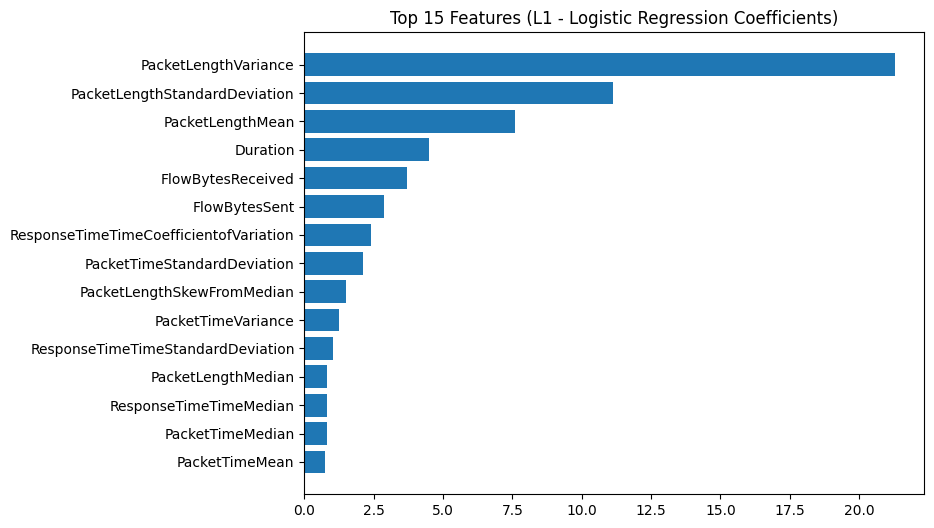

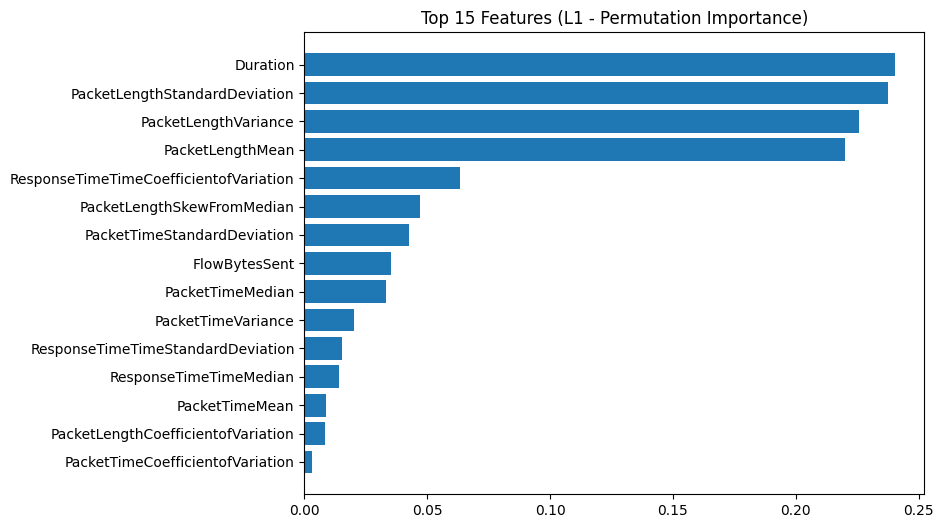

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.inspection import permutation_importance

# ---- Logistic Regression for L1 again ----
lr = LogisticRegression(max_iter=500, class_weight="balanced")
lr.fit(X1_train, y1_train)

# Get coefficients (absolute value for importance)
coef_importance = np.abs(lr.coef_[0])
feature_names = df_L1.drop(columns=["Label"]).columns

# Sort top 15
idx = np.argsort(coef_importance)[::-1][:15]
plt.figure(figsize=(8,6))
plt.barh(range(len(idx)), coef_importance[idx][::-1])
plt.yticks(range(len(idx)), [feature_names[i] for i in idx][::-1])
plt.title("Top 15 Features (L1 - Logistic Regression Coefficients)")
plt.show()

# ---- Permutation Importance on L1 ----
perm = permutation_importance(lr, X1_test, y1_test, n_repeats=5, random_state=42, n_jobs=-1)
sorted_idx = perm.importances_mean.argsort()[::-1][:15]

plt.figure(figsize=(8,6))
plt.barh(range(len(sorted_idx)), perm.importances_mean[sorted_idx][::-1])
plt.yticks(range(len(sorted_idx)), feature_names[sorted_idx][::-1])
plt.title("Top 15 Features (L1 - Permutation Importance)")
plt.show()


In [8]:
pip install torch torch-geometric -q


**GRAPH BUILDING FOR L1**

In [10]:
import torch
from torch_geometric.data import Data
import numpy as np
from sklearn.preprocessing import LabelEncoder

def build_graph_from_index(df, window=5):
    """
    Build graph from row index order (as proxy for time).
    Each node = one flow
    Edges connect each node to +/- 'window' neighbors.
    """

    # Separate features and label
    X = df.drop(columns=["Label"]).to_numpy()
    y = df["Label"].to_numpy()

    # Encode labels (string -> int)
    le = LabelEncoder()
    y = le.fit_transform(y)

    num_nodes = X.shape[0]

    # Node features & labels
    x = torch.tensor(X, dtype=torch.float)
    y = torch.tensor(y, dtype=torch.long)

    # Edge index: sliding window
    edge_index = []
    for i in range(num_nodes):
        for j in range(max(0, i-window), min(num_nodes, i+window+1)):
            if i != j:
                edge_index.append([i, j])

    edge_index = torch.tensor(edge_index, dtype=torch.long).T  # shape [2, E]

    return Data(x=x, edge_index=edge_index, y=y)

# Example: build on a small subset
subset = df_L1.sample(2000, random_state=42).reset_index(drop=True)
graph = build_graph_from_index(subset, window=5)

print(graph)
print("Nodes:", graph.num_nodes, "Edges:", graph.num_edges)
print("Class distribution:", torch.bincount(graph.y))


Data(x=[2000, 29], edge_index=[2, 19970], y=[2000])
Nodes: 2000 Edges: 19970
Class distribution: tensor([ 510, 1490])


**GRAPHSAGE FOR L1**

In [24]:
import random, numpy as np, torch
import torch.nn as nn, torch.nn.functional as F
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, roc_auc_score, confusion_matrix, classification_report
from torch_geometric.nn import SAGEConv

# --- reproducibility ---
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

set_seed(42)

# --- build train/val/test masks on the subset graph ---
data = graph
num_nodes = data.num_nodes
y_np = data.y.cpu().numpy()

train_idx, test_idx = train_test_split(np.arange(num_nodes), test_size=0.2, stratify=y_np, random_state=42)
train_idx, val_idx = train_test_split(train_idx, test_size=0.2, stratify=y_np[train_idx], random_state=42)

train_mask = torch.zeros(num_nodes, dtype=torch.bool)
val_mask = torch.zeros(num_nodes, dtype=torch.bool)
test_mask = torch.zeros(num_nodes, dtype=torch.bool)
train_mask[train_idx] = True
val_mask[val_idx] = True
test_mask[test_idx] = True
data.train_mask = train_mask
data.val_mask = val_mask
data.test_mask = test_mask

# --- model with BatchNorm + Dropout ---
class GraphSAGEStable(nn.Module):
    def __init__(self, in_channels, hidden_channels, num_classes=2, dropout=0.5):
        super().__init__()
        self.conv1 = SAGEConv(in_channels, hidden_channels)
        self.bn1 = nn.BatchNorm1d(hidden_channels)
        self.conv2 = SAGEConv(hidden_channels, hidden_channels)
        self.bn2 = nn.BatchNorm1d(hidden_channels)
        self.dropout = nn.Dropout(dropout)
        self.lin = nn.Linear(hidden_channels, num_classes)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = self.bn1(x)
        x = F.relu(x)
        x = self.dropout(x)
        x = self.conv2(x, edge_index)
        x = self.bn2(x)
        x = F.relu(x)
        x = self.dropout(x)
        return self.lin(x)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = GraphSAGEStable(in_channels=data.num_node_features, hidden_channels=64, dropout=0.5).to(device)
data = data.to(device)

# --- class weights from train labels ---
train_labels = data.y[data.train_mask].cpu().numpy()
class_w = compute_class_weight("balanced", classes=np.unique(train_labels), y=train_labels)
class_w = torch.tensor(class_w, dtype=torch.float).to(device)
criterion = nn.CrossEntropyLoss(weight=class_w)

optimizer = torch.optim.Adam(model.parameters(), lr=0.005, weight_decay=5e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=3)

# --- training loop with masked loss, gradient clipping, early stopping by val AUC ---
best_val_auc = 0.0
patience = 8
patience_cnt = 0
best_state = None

def evaluate_mask(mask):
    model.eval()
    with torch.no_grad():
        out = model(data.x, data.edge_index)
        logits = out[mask]
        probs = F.softmax(logits, dim=1)[:,1].cpu().numpy()
        preds = logits.argmax(dim=1).cpu().numpy()
        ys = data.y[mask].cpu().numpy()
    acc = accuracy_score(ys, preds)
    prf = precision_recall_fscore_support(ys, preds, average='binary', zero_division=0)
    auc = roc_auc_score(ys, probs) if len(np.unique(ys))>1 else float('nan')
    return acc, prf, auc, ys, preds, probs

for epoch in range(1, 101):
    model.train()
    optimizer.zero_grad()
    out = model(data.x, data.edge_index)
    logits_train = out[data.train_mask]
    y_train = data.y[data.train_mask]
    loss = criterion(logits_train, y_train)
    loss.backward()
    torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=2.0)
    optimizer.step()

    # eval on val
    val_acc, val_prf, val_auc, _, _, _ = evaluate_mask(data.val_mask)
    scheduler.step(val_auc if not np.isnan(val_auc) else 0.0)

    print(f"Epoch {epoch:03d}  Loss: {loss.item():.4f}  Val Acc: {val_acc:.4f}  Val AUC: {val_auc:.4f}")

    # early stopping on val AUC
    if val_auc > best_val_auc + 1e-4:
        best_val_auc = val_auc
        patience_cnt = 0
        best_state = model.state_dict()
        torch.save(best_state, "best_gnn_subset.pth")
    else:
        patience_cnt += 1
        if patience_cnt >= patience:
            print("Early stopping (no improvement).")
            break

# --- load best and evaluate on test ---
if best_state is not None:
    model.load_state_dict(best_state)
test_acc, test_prf, test_auc, ys, preds, probs = evaluate_mask(data.test_mask)
print("\nFINAL TEST RESULTS")
print("Test Acc:", test_acc, "Test P/R/F:", test_prf, "Test AUC:", test_auc)
print("Confusion Matrix:\n", confusion_matrix(ys, preds))
print("\nClassification Report:\n", classification_report(ys, preds))


Epoch 001  Loss: 0.7472  Val Acc: 0.7156  Val AUC: 0.6544
Epoch 002  Loss: 0.6755  Val Acc: 0.5250  Val AUC: 0.6637
Epoch 003  Loss: 0.6644  Val Acc: 0.5156  Val AUC: 0.6784
Epoch 004  Loss: 0.6635  Val Acc: 0.5375  Val AUC: 0.6829
Epoch 005  Loss: 0.6468  Val Acc: 0.5500  Val AUC: 0.6910
Epoch 006  Loss: 0.6360  Val Acc: 0.5719  Val AUC: 0.7022
Epoch 007  Loss: 0.6276  Val Acc: 0.5813  Val AUC: 0.7058
Epoch 008  Loss: 0.6331  Val Acc: 0.5875  Val AUC: 0.7126
Epoch 009  Loss: 0.6301  Val Acc: 0.5844  Val AUC: 0.7187
Epoch 010  Loss: 0.6186  Val Acc: 0.5844  Val AUC: 0.7246
Epoch 011  Loss: 0.6132  Val Acc: 0.5750  Val AUC: 0.7270
Epoch 012  Loss: 0.6146  Val Acc: 0.5594  Val AUC: 0.7301
Epoch 013  Loss: 0.6100  Val Acc: 0.5594  Val AUC: 0.7337
Epoch 014  Loss: 0.6121  Val Acc: 0.5594  Val AUC: 0.7404
Epoch 015  Loss: 0.6020  Val Acc: 0.5437  Val AUC: 0.7454
Epoch 016  Loss: 0.5931  Val Acc: 0.5250  Val AUC: 0.7513
Epoch 017  Loss: 0.6039  Val Acc: 0.5188  Val AUC: 0.7586
Epoch 018  Los

**GRAPH BUILDING FOR L2**

In [38]:
import torch
from torch_geometric.data import Data
import numpy as np
from sklearn.preprocessing import LabelEncoder

def build_graph_from_index(df, window=5):
    """
    Build graph from row index order (as proxy for time).
    Each node = one flow
    Edges connect each node to +/- 'window' neighbors.
    """

    # Separate features and label
    X = df.drop(columns=["Label"]).to_numpy()
    y = df["Label"].to_numpy()

    # Encode labels (string -> int)
    le = LabelEncoder()
    y = le.fit_transform(y)

    num_nodes = X.shape[0]

    # Node features & labels
    x = torch.tensor(X, dtype=torch.float)
    y = torch.tensor(y, dtype=torch.long)

    # Edge index: sliding window
    edge_index = []
    for i in range(num_nodes):
        for j in range(max(0, i-window), min(num_nodes, i+window+1)):
            if i != j:
                edge_index.append([i, j])

    edge_index = torch.tensor(edge_index, dtype=torch.long).T  # shape [2, E]

    return Data(x=x, edge_index=edge_index, y=y)

# Example: build on a small subset
subset_L2 = df_L2.sample(2000, random_state=42).reset_index(drop=True)
graph_L2 = build_graph_from_index(subset_L2, window=5)

print(graph_L2)
print("Nodes:", graph_L2.num_nodes, "Edges:", graph_L2.num_edges)
print("Class distribution:", torch.bincount(graph_L2.y))


Data(x=[2000, 29], edge_index=[2, 19970], y=[2000])
Nodes: 2000 Edges: 19970
Class distribution: tensor([ 152, 1848])


**GRAPHSAGE FOR L2**

In [39]:
# ------------------- L2 GRAPH (Malicious DoH vs Benign DoH) -------------------
data = graph_L2
num_nodes = data.num_nodes
y_np = data.y.cpu().numpy()

# Split into train/val/test
train_idx, test_idx = train_test_split(np.arange(num_nodes), test_size=0.2, stratify=y_np, random_state=42)
train_idx, val_idx = train_test_split(train_idx, test_size=0.2, stratify=y_np[train_idx], random_state=42)

train_mask = torch.zeros(num_nodes, dtype=torch.bool)
val_mask = torch.zeros(num_nodes, dtype=torch.bool)
test_mask = torch.zeros(num_nodes, dtype=torch.bool)
train_mask[train_idx] = True
val_mask[val_idx] = True
test_mask[test_idx] = True
data.train_mask = train_mask
data.val_mask = val_mask
data.test_mask = test_mask

# Build model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = GraphSAGEStable(in_channels=data.num_node_features, hidden_channels=64, dropout=0.5).to(device)
data = data.to(device)

# Class weights
train_labels = data.y[data.train_mask].cpu().numpy()
class_w = compute_class_weight("balanced", classes=np.unique(train_labels), y=train_labels)
class_w = torch.tensor(class_w, dtype=torch.float).to(device)
criterion = nn.CrossEntropyLoss(weight=class_w)

optimizer = torch.optim.Adam(model.parameters(), lr=0.005, weight_decay=5e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=3)


# --- training loop with masked loss, gradient clipping, early stopping by val AUC ---
best_val_auc = 0.0
patience = 8
patience_cnt = 0
best_state = None

def evaluate_mask(mask):
    model.eval()
    with torch.no_grad():
        out = model(data.x, data.edge_index)
        logits = out[mask]
        probs = F.softmax(logits, dim=1)[:,1].cpu().numpy()
        preds = logits.argmax(dim=1).cpu().numpy()
        ys = data.y[mask].cpu().numpy()
    acc = accuracy_score(ys, preds)
    prf = precision_recall_fscore_support(ys, preds, average='binary', zero_division=0)
    auc = roc_auc_score(ys, probs) if len(np.unique(ys))>1 else float('nan')
    return acc, prf, auc, ys, preds, probs

for epoch in range(1, 101):
    model.train()
    optimizer.zero_grad()
    out = model(data.x, data.edge_index)
    logits_train = out[data.train_mask]
    y_train = data.y[data.train_mask]
    loss = criterion(logits_train, y_train)
    loss.backward()
    torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=2.0)
    optimizer.step()

    # eval on val
    val_acc, val_prf, val_auc, _, _, _ = evaluate_mask(data.val_mask)
    scheduler.step(val_auc if not np.isnan(val_auc) else 0.0)

    print(f"Epoch {epoch:03d}  Loss: {loss.item():.4f}  Val Acc: {val_acc:.4f}  Val AUC: {val_auc:.4f}")

    # early stopping on val AUC
    if val_auc > best_val_auc + 1e-4:
        best_val_auc = val_auc
        patience_cnt = 0
        best_state = model.state_dict()
        torch.save(best_state, "best_gnn_subset.pth")
    else:
        patience_cnt += 1
        if patience_cnt >= patience:
            print("Early stopping (no improvement).")
            break

# --- load best and evaluate on test ---
if best_state is not None:
    model.load_state_dict(best_state)
test_acc, test_prf, test_auc, ys, preds, probs = evaluate_mask(data.test_mask)
print("\nFINAL TEST RESULTS")
print("Test Acc:", test_acc, "Test P/R/F:", test_prf, "Test AUC:", test_auc)
print("Confusion Matrix:\n", confusion_matrix(ys, preds))
print("\nClassification Report:\n", classification_report(ys, preds))


Epoch 001  Loss: 0.7311  Val Acc: 0.9250  Val AUC: 0.7438
Epoch 002  Loss: 0.6597  Val Acc: 0.9250  Val AUC: 0.7549
Epoch 003  Loss: 0.6126  Val Acc: 0.9250  Val AUC: 0.7535
Epoch 004  Loss: 0.6206  Val Acc: 0.9187  Val AUC: 0.7597
Epoch 005  Loss: 0.5875  Val Acc: 0.9062  Val AUC: 0.7676
Epoch 006  Loss: 0.5833  Val Acc: 0.8875  Val AUC: 0.7791
Epoch 007  Loss: 0.6045  Val Acc: 0.8719  Val AUC: 0.8008
Epoch 008  Loss: 0.5697  Val Acc: 0.8469  Val AUC: 0.8160
Epoch 009  Loss: 0.5616  Val Acc: 0.8469  Val AUC: 0.8331
Epoch 010  Loss: 0.5236  Val Acc: 0.8156  Val AUC: 0.8381
Epoch 011  Loss: 0.5231  Val Acc: 0.7906  Val AUC: 0.8426
Epoch 012  Loss: 0.5467  Val Acc: 0.7719  Val AUC: 0.8484
Epoch 013  Loss: 0.5087  Val Acc: 0.7656  Val AUC: 0.8525
Epoch 014  Loss: 0.5126  Val Acc: 0.7594  Val AUC: 0.8553
Epoch 015  Loss: 0.5205  Val Acc: 0.7688  Val AUC: 0.8599
Epoch 016  Loss: 0.5042  Val Acc: 0.7656  Val AUC: 0.8656
Epoch 017  Loss: 0.5109  Val Acc: 0.7750  Val AUC: 0.8688
Epoch 018  Los